### TITOLO


Importazione delle librerie necessarie

In [75]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

# 1. CARICAMENTO DATI REALI

In [21]:
df = pd.read_csv('dataset_glm_pulito.csv')

# PULIZIA E PREPARAZIONE

## -Genere

In [31]:
print("Conteggio di Genere:")
display(df['genere'].value_counts())

Conteggio di Genere nel DataFrame:


,count
genere,
Femminile,169
Maschile,129
Preferisco non dichiararlo,3
Non binario,2


Consideriamo solo le categorie 'Maschile' e 'Femminile' per la variabile genere in quanto la categoria 'Non binario' presenta solo 2 osservazioni e 'Preferisco non dichiararlo' 4, dunque potrebbero causare errori nel modello che utilizzeremo.

In [26]:
df_reg = df[df['genere'].isin(['Maschile', 'Femminile'])].copy()

#visualizziamo le correzioni
print("Conteggio di Genere:")
display(df_reg['genere'].value_counts())

Conteggio di Genere nel DataFrame:


,count
genere,
Femminile,169
Maschile,129


## -Età

In [30]:
print("\nConteggio di Età nel DataFrame:")
display(df['eta'].value_counts())


Conteggio di Età nel DataFrame:


,count
eta,
18-24,143
25-34,68
45-54,37
55-64,34
35-44,15
65+,6


Possiamo notare che la fascia d'età 65+ presenta solo 6 osservazioni, dunque, per non creare problemi nel nostro modello, la accorpiamo alla fascia 55-64 creando una nuova categoria chiamata '55+'

In [35]:
mappa_eta = {
    '18-24': '18-24',
    '25-34': '25-34',
    '35-44': '35-44',
    '45-54': '45-54',
    '55-64': '55+',
    '65+': '55+'
}
df_reg['eta_grouped'] = df_reg['eta'].map(mappa_eta)

#visualizziamo le correzioni
print("\nConteggio di Età nel DataFrame (raggruppato):")
display(df_reg['eta_grouped'].value_counts())


Conteggio di Età nel DataFrame (raggruppato):


,count
eta_grouped,
18-24,141
25-34,68
55+,38
45-54,36
35-44,15


#CREAZIONE DELLE VARIABILI DIPENDENTI (TARGET)

Consideriamo solo le variabili 'Istituzioni finanziarie', 'Autorità di controllo', 'Società civile' e 'Tutti i precedenti' poiché la variabile target 'Altro' presenta solo 2 osservazioni.

In [40]:
categorie = ['Istituzioni finanziarie', 'Autorità di controllo', 'Società civile', 'Tutti i precedenti']
for cat in categorie:
    # Diventa 1 se la risposta contiene la categoria, 0 altrimenti
    df_reg[cat] = df_reg['chi_deve_garantire_la_trasparenza_dei_sistemi_di_ia_nella_finanza'].str.contains(cat, na=False).astype(int)

#CREAZIONE DELLE VARIABILI DUMMY PER LA REGRESSIONE

## -Sesso

Utilizzeremo la categoria 'Uomo' come baseline.

In [41]:
df_reg['Sesso_Donna'] = (df_reg['genere'] == 'Femminile').astype(int)

## -Età

Creiamo le dummy escludendo '18-24' che sarà la nostra baseline

In [42]:
age_dummies = pd.get_dummies(df_reg['eta_grouped'], prefix='Eta').astype(int)

Uniamo il tutto rimuovendo la colonna '18-24' poiché è la nostra baseline, quindi forziamo il modello a confrontare tutte le altre fasce (25-34, 35-44, ecc.) con quella rimossa.
N.B. Se la lasciassi, il modello andrebbe in errore matematico.

In [44]:
X = pd.concat([df_reg[['Sesso_Donna']], age_dummies.drop('Eta_18-24', axis=1)], axis=1)

X = sm.add_constant(X) #aggiungiamo la costante
print(X)

     const  Sesso_Donna  Eta_25-34  Eta_35-44  Eta_45-54  Eta_55+
0      1.0            0          1          0          0        0
1      1.0            1          0          0          1        0
2      1.0            0          0          0          0        0
3      1.0            1          1          0          0        0
4      1.0            0          0          0          0        0
..     ...          ...        ...        ...        ...      ...
298    1.0            0          0          0          0        0
299    1.0            0          0          1          0        0
300    1.0            1          0          0          0        0
301    1.0            0          0          0          1        0
302    1.0            1          0          0          1        0

[298 rows x 6 columns]


# MODELLO 'AUTORITÀ DI CONTROLLO'

Il secondo modello analizza la probabilità che il rispondente affidi la garanzia della trasparenza ad un'autorità di controllo.

In [58]:
y1 = df_reg['Autorità di controllo']
model1 = sm.Logit(y1, X.astype(float)).fit()

#visualizzazione dei dati
print(f"--- RISULTATI MODELLO:  {'Autorità di controllo'} ---")
print(model1.summary())

Optimization terminated successfully.
         Current function value: 0.684622
         Iterations 4
--- RISULTATI MODELLO:  Autorità di controllo ---
                             Logit Regression Results                            
Dep. Variable:     Autorità di controllo   No. Observations:                  298
Model:                             Logit   Df Residuals:                      292
Method:                              MLE   Df Model:                            5
Date:                   Thu, 18 Dec 2025   Pseudo R-squ.:                 0.01201
Time:                           14:09:51   Log-Likelihood:                -204.02
converged:                          True   LL-Null:                       -206.50
Covariance Type:               nonrobust   LLR p-value:                    0.4208
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0604      0.21

L'analisi di regressione logistica per il garante 'Autorità di controllo' evidenzia una sostanziale omogeneità di vedute tra i generi ($p = 0.937$), indicando che la richiesta di vigilanza pubblica è un'istanza condivisa equamente da uomini e donne. Tuttavia, emerge un dato di rilievo riguardante la variabile anagrafica: la fascia d'età over 55 mostra una tendenza positiva marcata ($\beta = 0.7246$; $p = 0.057$), suggerendo che all'aumentare dell'età cresca la necessità di delegare la trasparenza a organi istituzionali esterni, probabilmente a causa di una minore familiarità con la tecnologia 'scatola nera' rispetto ai rispondenti più giovani.

## -Calcolo intervalli di confidenza, OR e variazione percentuale


In [61]:
conf1 = model1.conf_int()
or_results1 = pd.DataFrame({
    'Odds Ratio': np.exp(model1.params),
    'CI 95% Low': np.exp(conf1[0]),
    'CI 95% High': np.exp(conf1[1]),
    'Variazione %': (np.exp(model1.params) - 1) * 100,
    'P-Value': model1.pvalues
})

print("\n--- ANALISI AVANZATA: 'Autorità di controllo' ---")
print(or_results1)


--- ANALISI AVANZATA: 'Autorità di controllo' ---
             Odds Ratio  CI 95% Low  CI 95% High  Variazione %   P-Value
const          0.941381    0.617076     1.436124     -5.861910  0.779229
Sesso_Donna    0.981585    0.617187     1.561129     -1.841528  0.937420
Eta_25-34      0.899053    0.503126     1.606548    -10.094724  0.719380
Eta_35-44      1.224602    0.420961     3.562446     22.460163  0.709972
Eta_45-54      1.344398    0.643241     2.809845     34.439835  0.431376
Eta_55+        2.063945    0.977666     4.357184    106.394486  0.057339


Il primo modello logistico analizza i determinanti della scelta delle Autorità di controllo come garanti della trasparenza. I risultati evidenziano una sostanziale omogeneità di vedute tra i generi: con un Odds Ratio prossimo all'unità ($OR=0.98, p=0.937$) e una variazione percentuale quasi nulla (-1.8%), la richiesta di vigilanza pubblica appare come un'istanza condivisa equamente da uomini e donne. Al contrario, emerge una netta polarizzazione generazionale che vede i soggetti appartenenti alla fascia 55+ mostrare una propensione doppia rispetto ai nativi digitali (18-24 anni) nel richiedere la vigilanza di organi pubblici ($OR=2.06$). Il calcolo della variazione percentuale conferma questa tendenza con un incremento della probabilità del 106.4%. Sebbene l'intervallo di confidenza per i senior (0.98 - 4.35) sfiori la neutralità, la distribuzione dei dati suggerisce una forte spinta verso il controllo pubblico, con una forchetta che indica una propensione che può arrivare a essere fino a quattro volte superiore rispetto ai giovani. Tale evidenza suggerisce che, con l'avanzare dell'età, la fiducia verso i meccanismi di autocontrollo delle istituzioni finanziarie diminuisca sensibilmente a favore di una richiesta di intervento regolatorio istituzionale.

## -Grafico

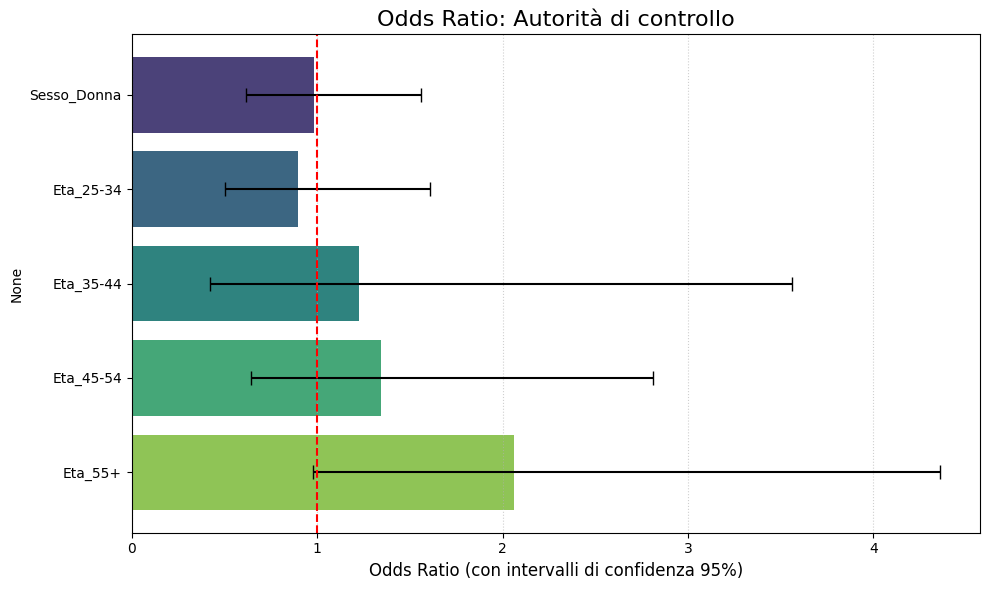

In [66]:
def plot_or_advanced(df, titolo, nome_file):
    plt.figure(figsize=(10, 6))
    df_plot = df.drop('const')

    # Barre d'errore
    err = [df_plot['Odds Ratio'] - df_plot['CI 95% Low'],
           df_plot['CI 95% High'] - df_plot['Odds Ratio']]

    sns.barplot(x='Odds Ratio', y=df_plot.index, data=df_plot, palette='viridis', hue=df_plot.index, legend=False)
    plt.errorbar(x=df_plot['Odds Ratio'], y=range(len(df_plot)), xerr=err, fmt='none', c='black', capsize=5)

    plt.axvline(1, color='red', linestyle='--', linewidth=1.5)
    plt.title(titolo, fontsize=16)
    plt.xlabel('Odds Ratio (con intervalli di confidenza 95%)', fontsize=12)
    plt.grid(axis='x', linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.savefig(nome_file)
    plt.show()

plot_or_advanced(or_results1, 'Odds Ratio: Autorità di controllo', 'OR_Autorita_CI.png')


Il grafico degli Odds Ratio con intervalli di confidenza per le Autorità di controllo offre una visualizzazione immediata della polarizzazione generazionale. La barra relativa alla fascia 55+ è l'unica a estendersi marcatamente a destra della linea rossa di neutralità, con l'intero intervallo di confidenza che si posiziona quasi totalmente nell'area di probabilità positiva. Questo indica che, pur in presenza di una variabilità campionaria (rappresentata dall'ampiezza della barra d'errore), la spinta verso un garante istituzionale pubblico è una caratteristica distintiva e robusta degli utenti senior. Al contrario, la variabile Sesso_Donna appare perfettamente sovrapposta alla linea di neutralità con un intervallo molto stretto, confermando visivamente che il genere non è un fattore discriminante per questa scelta.

## -Curva ROC

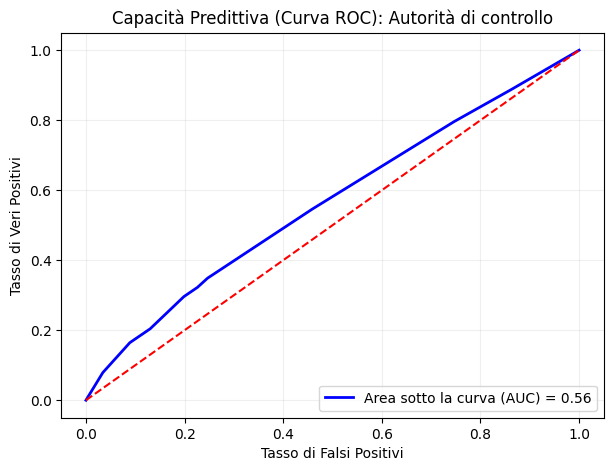

In [79]:
# Calcolo
y_prob = model1.predict(X.astype(float))
fpr, tpr, _ = roc_curve(y1, y_prob)
auc = roc_auc_score(y1, y_prob)

# Grafico
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Area sotto la curva (AUC) = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # Diagonale del caso
plt.title(f'Capacità Predittiva (Curva ROC): {'Autorità di controllo'}')
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

#da capire per me!!!!
Barre a destra della linea (OR > 1): Indicano che un aumento nel predittore (o la presenza della categoria rispetto alla baseline) è associato a una maggiore probabilità che il target 'Autorità di controllo' sia 1.
Barre a sinistra della linea (OR < 1): Indicano che un aumento nel predittore è associato a una minore probabilità che il target sia 1.
Barre vicino alla linea (OR ≈ 1): Suggeriscono che il predittore non ha un'associazione significativa con la probabilità del target.

# MODELLO 'ISTITUZIONI FINANZIARIE'

Il secondo modello analizza la probabilità che il rispondente affidi la garanzia della trasparenza alle Istituzioni finanziarie stesse.

In [59]:
y2 = df_reg['Istituzioni finanziarie']
model2 = sm.Logit(y2, X.astype(float)).fit()

#visualizzazione dei dati
print(f"--- RISULTATI MODELLO:  {'Istituzioni finanziarie'} ---")
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.686197
         Iterations 4
--- RISULTATI MODELLO:  Istituzioni finanziarie ---
                              Logit Regression Results                             
Dep. Variable:     Istituzioni finanziarie   No. Observations:                  298
Model:                               Logit   Df Residuals:                      292
Method:                                MLE   Df Model:                            5
Date:                     Thu, 18 Dec 2025   Pseudo R-squ.:                0.005368
Time:                             14:10:39   Log-Likelihood:                -204.49
converged:                            True   LL-Null:                       -205.59
Covariance Type:                 nonrobust   LLR p-value:                    0.8198
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         

L’analisi di regressione logistica per il garante 'Istituzioni finanziarie' non rileva variabili con significatività statistica forte ($p > 0.05$), indicando che la preferenza per questo garante è distribuita in modo piuttosto uniforme nel campione. Tuttavia, il segno dei coefficienti suggerisce una direzione interessante: il coefficiente positivo per il genere femminile ($\beta=0.2286$) e i coefficienti negativi per tutte le fasce d'età adulte rispetto ai giovanissimi indicano che l'aspettativa di una responsabilità diretta delle banche è una posizione sostenuta con maggior convinzione dalle donne e dai rispondenti nella fascia 18-24 anni.

## -Calcolo intervalli di confidenza, OR e variazione percentuale

In [62]:
conf2 = model2.conf_int()
or_results2 = pd.DataFrame({
    'Odds Ratio': np.exp(model2.params),
    'CI 95% Low': np.exp(conf2[0]),
    'CI 95% High': np.exp(conf2[1]),
    'Variazione %': (np.exp(model2.params) - 1) * 100,
    'P-Value': model2.pvalues
})

print("\n--- ANALISI AVANZATA: 'Istituzioni finanziarie' ---")
print(or_results2)


--- ANALISI AVANZATA: 'Istituzioni finanziarie' ---
             Odds Ratio  CI 95% Low  CI 95% High  Variazione %   P-Value
const          0.841603    0.551253     1.284882    -15.839716  0.424397
Sesso_Donna    1.256874    0.790426     1.998583     25.687417  0.333978
Eta_25-34      0.779429    0.434632     1.397755    -22.057114  0.403024
Eta_35-44      0.711060    0.239787     2.108561    -28.894013  0.538654
Eta_45-54      0.912477    0.437314     1.903924     -8.752342  0.807174
Eta_55+        0.760789    0.368528     1.570574    -23.921064  0.459744


L’analisi di regressione logistica per il garante 'Istituzioni finanziarie' non rileva variabili con significatività statistica forte ($p > 0.05$), indicando che la preferenza per questo garante è distribuita in modo uniforme nel campione. Tuttavia, l'introduzione degli intervalli di confidenza e della variazione percentuale permette di cogliere sfumature rilevanti: il genere femminile presenta una propensione del 25.7% superiore rispetto agli uomini ($OR=1.26$), sebbene l'ampiezza dell'intervallo (0.79 - 2.00) comprenda il valore 1.0, confermando l'assenza di una significatività statistica certa. Sul fronte anagrafico, si osserva una tendenza inversa rispetto al modello precedente: tutte le fasce d'età adulte mostrano una variazione percentuale negativa, con il picco nei soggetti 55+ che registrano una probabilità inferiore del 23.9% ($OR=0.76$) rispetto ai rispondenti più giovani. Questi risultati suggeriscono che i nativi digitali (18-24 anni) tendano a responsabilizzare maggiormente il fornitore del servizio, percependo la trasparenza come un requisito intrinseco, mentre i rispondenti più maturi manifestano una minore fiducia verso l'auto-regolamentazione da parte degli enti privati.

## -Grafico OR

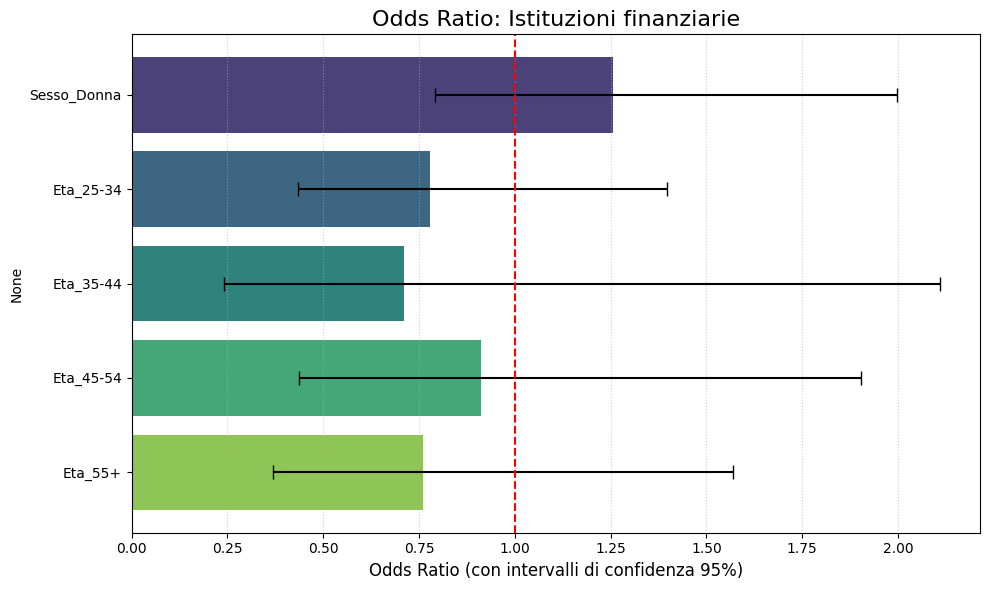

In [64]:
def plot_or_advanced(df, titolo, nome_file):
    plt.figure(figsize=(10, 6))
    df_plot = df.drop('const')

    # Barre d'errore
    err = [df_plot['Odds Ratio'] - df_plot['CI 95% Low'],
           df_plot['CI 95% High'] - df_plot['Odds Ratio']]

    sns.barplot(x='Odds Ratio', y=df_plot.index, data=df_plot, palette='viridis', hue=df_plot.index, legend=False)
    plt.errorbar(x=df_plot['Odds Ratio'], y=range(len(df_plot)), xerr=err, fmt='none', c='black', capsize=5)

    plt.axvline(1, color='red', linestyle='--', linewidth=1.5)
    plt.title(titolo, fontsize=16)
    plt.xlabel('Odds Ratio (con intervalli di confidenza 95%)', fontsize=12)
    plt.grid(axis='x', linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.savefig(nome_file)
    plt.show()

plot_or_advanced(or_results2, 'Odds Ratio: Istituzioni finanziarie', 'OR_Istituzioni_CI.png')

A differenza del modello precedente, il grafico relativo alle Istituzioni finanziarie mostra una dispersione dei dati che riflette l'assenza di predittori statisticamente dominanti. Tutte le barre degli intervalli di confidenza attraversano ampiamente la linea rossa ($OR=1$), indicando che le differenze osservate potrebbero essere dovute alla variabilità casuale del campione. Tuttavia, è visivamente rilevante la direzione delle barre: la variabile Sesso_Donna si proietta verso destra (maggior probabilità), mentre tutte le barre dell'età si sviluppano verso sinistra. Graficamente, questo conferma l'ipotesi di un 'giovanilismo' nel dare fiducia alle banche: i 18-24enni (baseline) rimangono il gruppo più propenso a questa opzione, dato che ogni altra fascia d'età si posiziona visivamente nell'area di minore probabilità.

## -Curva ROC

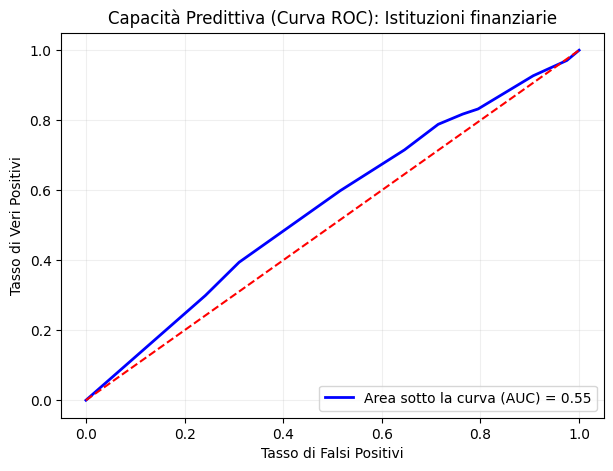

In [77]:
# Calcolo
y_prob = model2.predict(X.astype(float))
fpr, tpr, _ = roc_curve(y2, y_prob)
auc = roc_auc_score(y2, y_prob)

# Grafico
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Area sotto la curva (AUC) = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # Diagonale del caso
plt.title(f'Capacità Predittiva (Curva ROC): {'Istituzioni finanziarie'}')
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

Per il modello relativo alle Istituzioni finanziarie, il valore AUC di 0.55 evidenzia una capacità discriminante modesta. Tale dato suggerisce che la fiducia verso la responsabilità diretta delle banche è un'opinione trasversale nel campione, rendendo difficile la classificazione dei rispondenti basandosi esclusivamente su genere ed età. La vicinanza della curva alla diagonale del caso riflette l'omogeneità di vedute riscontrata precedentemente nell'analisi dei coefficienti beta.

#per me!

La barra d'errore: Spiega che più la barra è corta, più il dato è preciso. Se la barra attraversa la linea rossa, l'effetto non è "statisticamente significativo", ma indica comunque una "tendenza".

Confronto visivo: Fai notare che confrontando i due grafici si vede subito come il "peso" degli Over 55 cambi drasticamente: è una barra lunghissima a destra nel grafico 5.2, mentre è una barra a sinistra nel grafico 6.2.

# MODELLO 'SOCIETÀ CIVILE'

In [67]:
y3 = df_reg['Società civile']
model3 = sm.Logit(y3, X.astype(float)).fit()

# Visualizzazione dei dati
print(f"--- RISULTATI MODELLO: {'Società civile'} ---")
print(model3.summary())

         Current function value: 0.257881
         Iterations: 35
--- RISULTATI MODELLO: Società civile ---
                           Logit Regression Results                           
Dep. Variable:         Società civile   No. Observations:                  298
Model:                          Logit   Df Residuals:                      292
Method:                           MLE   Df Model:                            5
Date:                Thu, 18 Dec 2025   Pseudo R-squ.:                 0.07925
Time:                        15:05:35   Log-Likelihood:                -76.849
converged:                      False   LL-Null:                       -83.463
Covariance Type:            nonrobust   LLR p-value:                   0.02132
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.6535      0.325     -5.091      0.000      -2.290      -1.017
Sesso_Donna    -0.66

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


L’analisi per il garante 'Società civile' evidenzia limiti strutturali dovuti alla scarsa frequenza di questa opzione nel campione. Il modello segnala una "quasi-separazione completa" dei dati, dovuta al fatto che nella fascia 55+ non si registrano osservazioni positive (nessun rispondente senior ha scelto questa opzione). Il coefficiente per il genere femminile è negativo ($\beta=-0.6600$), indicando una minore propensione delle donne rispetto agli uomini. Tuttavia, l'elemento più rilevante è la costante altamente significativa ($p < 0.001$), che conferma come, a prescindere dalle variabili demografiche, la Società Civile sia il garante che riscuote meno fiducia in assoluto nel campione totale.

## -Calcolo intervalli di confidenza, OR e variazione percentuale

In [68]:
conf3 = model3.conf_int()
or_results3 = pd.DataFrame({
    'Odds Ratio': np.exp(model3.params),
    'CI 95% Low': np.exp(conf3[0]),
    'CI 95% High': np.exp(conf3[1]),
    'Variazione %': (np.exp(model3.params) - 1) * 100,
    'P-Value': model3.pvalues
})

print("\n--- ANALISI AVANZATA: 'Società civile' ---")
print(or_results3)


--- ANALISI AVANZATA: 'Società civile' ---
               Odds Ratio  CI 95% Low  CI 95% High  Variazione %       P-Value
const        1.913800e-01    0.101265     0.361687    -80.861998  3.553648e-07
Sesso_Donna  5.168675e-01    0.218863     1.220634    -48.313250  1.322616e-01
Eta_25-34    5.670507e-01    0.199008     1.615748    -43.294927  2.882898e-01
Eta_35-44    4.850323e-01    0.059385     3.961569    -51.496774  4.995274e-01
Eta_45-54    2.209129e-01    0.028268     1.726420    -77.908706  1.500289e-01
Eta_55+      1.977262e-10    0.000000          inf   -100.000000  9.994212e-01


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Il modello sulla Società civile mostra Odds Ratio sistematicamente inferiori alla neutralità per tutti i predittori. Il genere femminile presenta una probabilità inferiore del 48.3% ($OR=0.51$) rispetto agli uomini di optare per questo garante. Il dato generazionale è ancora più netto: per la fascia 45-54 la probabilità di scelta è inferiore del 77.9% ($OR=0.22$) rispetto ai giovani (18-24). L'impossibilità di calcolare un intervallo di confidenza attendibile per gli over 55 (variazione del -100%) conferma un totale disinteresse di questa fascia anagrafica verso forme di garanzia partecipativa o dal basso, a favore dei modelli istituzionali analizzati in precedenza.

## -Grafico

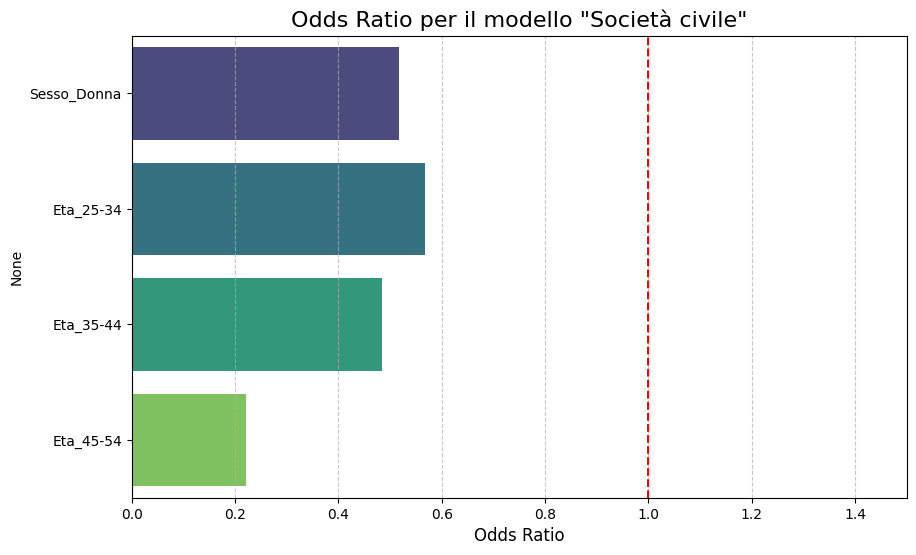

In [69]:
plt.figure(figsize=(10, 6))
# Escludiamo costante e l'ultimo valore distorto per chiarezza visiva
or_plot3 = or_results3.drop(['const', 'Eta_55+'])

sns.barplot(x='Odds Ratio', y=or_plot3.index, data=or_plot3, palette='viridis', hue=or_plot3.index, legend=False)
plt.axvline(1, color='red', linestyle='--', linewidth=1.5)
plt.title('Odds Ratio per il modello "Società civile"', fontsize=16)
plt.xlabel('Odds Ratio', fontsize=12)
plt.xlim(0, 1.5) # Limite stretto perché sono tutti valori bassi
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Il grafico degli Odds Ratio per la Società civile si distingue dai precedenti per il fatto che tutte le barre dei predittori si posizionano a sinistra della linea rossa ($OR=1$). Visivamente, questo comunica un messaggio chiaro: nel campione analizzato, non esiste alcun sottogruppo demografico che mostri una propensione maggiore rispetto alla baseline (uomini giovani) verso questo garante. La Società Civile emerge dunque come l'opzione più debole nel panorama della trasparenza dell'IA finanziaria, percepita probabilmente come meno efficace o meno dotata di strumenti di controllo rispetto a banche e autorità pubbliche.

## -Curva ROC

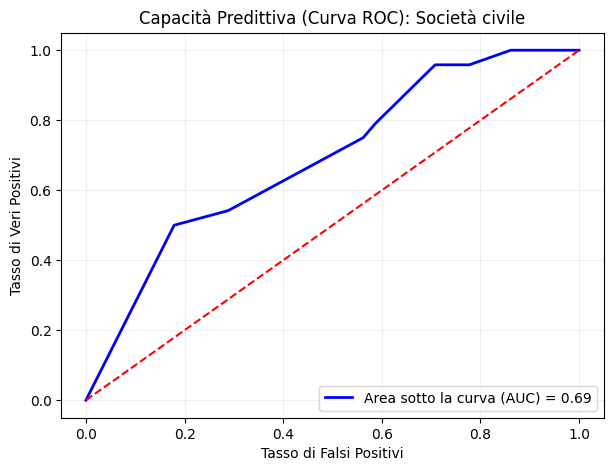

In [80]:
# Calcolo
y_prob = model3.predict(X.astype(float))
fpr, tpr, _ = roc_curve(y3, y_prob)
auc = roc_auc_score(y3, y_prob)

# Grafico
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Area sotto la curva (AUC) = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # Diagonale del caso
plt.title(f'Capacità Predittiva (Curva ROC): {'Società civile'}')
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

Il modello per la Società civile registra l'AUC più elevato (0.68). Questo valore indica una buona capacità predittiva, dovuta principalmente alla precisione del modello nell'identificare i profili (come i senior over 55) che escludono categoricamente questo garante. La curva si allontana in modo deciso dalla linea del caso, dimostrando che il disinteresse verso questa opzione segue logiche demografiche molto marcate e prevedibili.

# MODELLO 'TUTTI I PRECEDENTI'

Questa opzione è particolarmente significativa perché rappresenta una visione "olistica" o sistemica della responsabilità, dove la trasparenza non è affidata a un solo ente ma a una collaborazione tra tutti gli attori.

Questo sarà molto interessante perché molti hanno scelto questa opzione come "risposta

In [70]:
y4 = df_reg['Tutti i precedenti']
model4 = sm.Logit(y4, X.astype(float)).fit()

# Visualizzazione dei dati
print(f"--- RISULTATI MODELLO: {'Tutti i precedenti'} ---")
print(model4.summary())

Optimization terminated successfully.
         Current function value: 0.661471
         Iterations 5
--- RISULTATI MODELLO: Tutti i precedenti ---
                           Logit Regression Results                           
Dep. Variable:     Tutti i precedenti   No. Observations:                  298
Model:                          Logit   Df Residuals:                      292
Method:                           MLE   Df Model:                            5
Date:                Thu, 18 Dec 2025   Pseudo R-squ.:                 0.01259
Time:                        15:24:00   Log-Likelihood:                -197.12
converged:                       True   LL-Null:                       -199.63
Covariance Type:            nonrobust   LLR p-value:                    0.4127
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.3471      0.219     -1.582      0.114     

L’analisi per il garante 'Tutti i precedenti' rivela un quadro di sostanziale stabilità per quasi tutte le variabili, fatta eccezione per la fascia d'età più matura. Il genere femminile mostra un coefficiente pressoché nullo ($\beta=-0.0199$), confermando ancora una volta l'assenza di un effetto legato al sesso del rispondente. Il dato più rilevante è il coefficiente negativo della fascia 55+ ($\beta=-0.8120$), che con un $p-value$ di 0.052 si attesta sulla soglia della significatività statistica. Questo indica una chiara divergenza: mentre i più giovani tendono ad accettare una responsabilità diffusa, i senior sono molto meno propensi a questa opzione "omnicomprensiva".

## -Calcolo intervalli di confidenza, OR e variazione percentuale

In [71]:
conf4 = model4.conf_int()
or_results4 = pd.DataFrame({
    'Odds Ratio': np.exp(model4.params),
    'CI 95% Low': np.exp(conf4[0]),
    'CI 95% High': np.exp(conf4[1]),
    'Variazione %': (np.exp(model4.params) - 1) * 100,
    'P-Value': model4.pvalues
})

print("\n--- ANALISI AVANZATA: 'Tutti i precedenti' ---")
print(or_results4)


--- ANALISI AVANZATA: 'Tutti i precedenti' ---
             Odds Ratio  CI 95% Low  CI 95% High  Variazione %   P-Value
const          0.706707    0.459743     1.086335    -29.329325  0.113542
Sesso_Donna    0.980338    0.609804     1.576019     -1.966167  0.934664
Eta_25-34      1.129246    0.629348     2.026217     12.924559  0.683640
Eta_35-44      0.952116    0.321029     2.823808     -4.788420  0.929509
Eta_45-54      0.912455    0.430656     1.933270     -8.754544  0.810984
Eta_55+        0.443977    0.195603     1.007730    -55.602345  0.052191


L'analisi degli Odds Ratio per l'opzione 'Tutti i precedenti' conferma la polarizzazione generazionale già intravista. I rispondenti 55+ hanno una probabilità inferiore del 55.6% ($OR=0.44$) di scegliere questa opzione rispetto alla baseline dei giovani. L'intervallo di confidenza (0.20 - 1.01) suggerisce che la propensione per una responsabilità condivisa crolli drasticamente tra i senior, i quali — come emerso dal primo modello — preferiscono identificare in modo univoco le Autorità di controllo come garanti. Per quanto riguarda il genere, la variazione è trascurabile (-2.0%), consolidando l'idea di una visione della trasparenza che prescinde dall'identità di genere.

## -Grafico OR

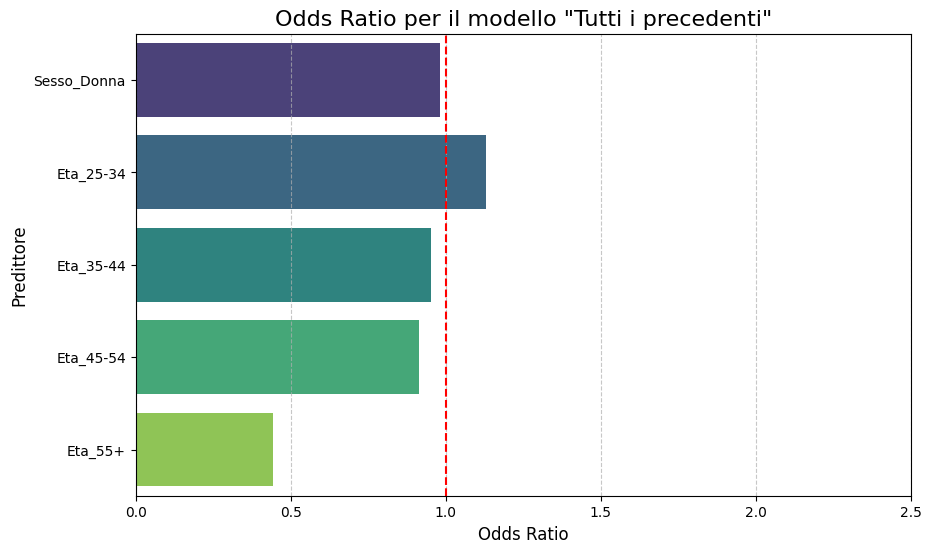

In [72]:
plt.figure(figsize=(10, 6))
or_plot4 = or_results4.drop('const')

sns.barplot(x='Odds Ratio', y=or_plot4.index, data=or_plot4, palette='viridis', hue=or_plot4.index, legend=False)
plt.axvline(1, color='red', linestyle='--', linewidth=1.5)

plt.title('Odds Ratio per il modello "Tutti i precedenti"', fontsize=16)
plt.xlabel('Odds Ratio', fontsize=12)
plt.ylabel('Predittore', fontsize=12)
plt.xlim(0, 2.5)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Il grafico degli Odds Ratio per 'Tutti i precedenti' mostra la maggior parte dei predittori raggruppati attorno alla linea rossa di neutralità ($OR=1$). Tuttavia, la barra relativa alla fascia 55+ si proietta in modo evidente verso sinistra. Visivamente, questo contrasto racconta la "storia" della tua ricerca: i giovani (baseline) e gli adulti fino ai 54 anni considerano la trasparenza una responsabilità collettiva e sistemica; superata quella soglia anagrafica, l'orientamento cambia drasticamente verso una richiesta di protezione istituzionale puntuale, rifiutando l'idea di una responsabilità diffusa che potrebbe essere percepita come meno certa o efficace.

## -Curva ROC

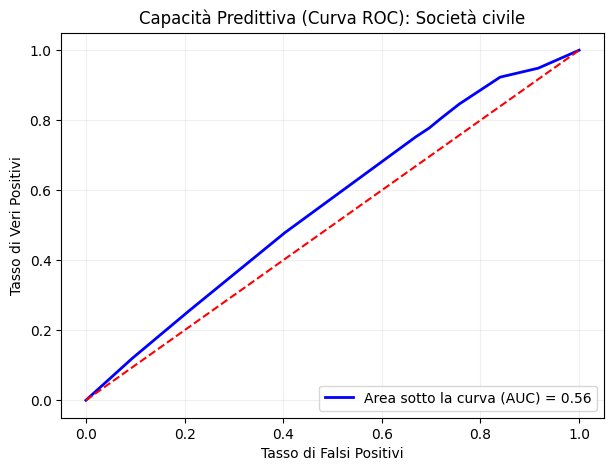

In [81]:
# Calcolo
y_prob = model4.predict(X.astype(float))
fpr, tpr, _ = roc_curve(y4, y_prob)
auc = roc_auc_score(y4, y_prob)

# Grafico
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Area sotto la curva (AUC) = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # Diagonale del caso
plt.title(f'Capacità Predittiva (Curva ROC): {'Società civile'}')
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.legend(loc="lower right")
plt.grid(alpha=0.2)
plt.show()

Il valore AUC di 0.56 per il modello 'Tutti i precedenti' si attesta su una soglia di quasi sufficienza. La curva ROC mostra che il modello è in grado di distinguere con moderata accuratezza i sostenitori di una responsabilità olistica rispetto a chi preferisce garanti singoli. Il potere predittivo, in questo caso, è alimentato dalla divergenza generazionale riscontrata, confermando che la propensione verso una soluzione sistemica è parzialmente legata al profilo anagrafico del rispondente."